In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    # dict(name="fixfloorbase", id="xph14-newalldisabled_lofloors", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="base", id="xph14ab-merge_master", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="upwind_cellaverage", id="xph14d-upwind_cellaverage", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="reducerec", id="xph14b-lower_rec_rate", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="No Rrec", id="xph14c-no_r_rec", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="No Rrec, Krec x1e-2", id="xph14cb-norrec_Krec_x0.01", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="No Rrec, Krec x1e-3", id="xph14cc-norrec_Krec_x0.001", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="No Rrec, Krec x1e-5", id="xph14cd-norrec_Krec_x1e-5", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="No Rrec, Krec x1e-7", id="xph14ce-norrec_Krec_x1e-7", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case xph14ab-merge_master
-----------------------

Unnormalising with xHermes
- Reading case xph14d-upwind_cellaverage
-----------------------

Unnormalising with xHermes


In [4]:
# ds = cs["newalldisabled_lopnfloor"].ds
# ds = cs["newalldisabled_flushnn"].ds
# ds = cs["newalldisabled_losecondfloor"].ds
# ds = cs["fix_dnnnn"].ds
# ds = cs["alldisabled"].ds
# ds = cs["upwind1stord_lofloor"].ds
# ds = cs["fixfloorbase_addrec"].ds
# ds = cs["reducerec"].ds
# ds = cs["no_r_rec"].ds
ds = cs["upwind_cellaverage"].ds.isel(t=-1)

*****************************
Excel saves precision as it appears, not as what the number has.......
*****************************


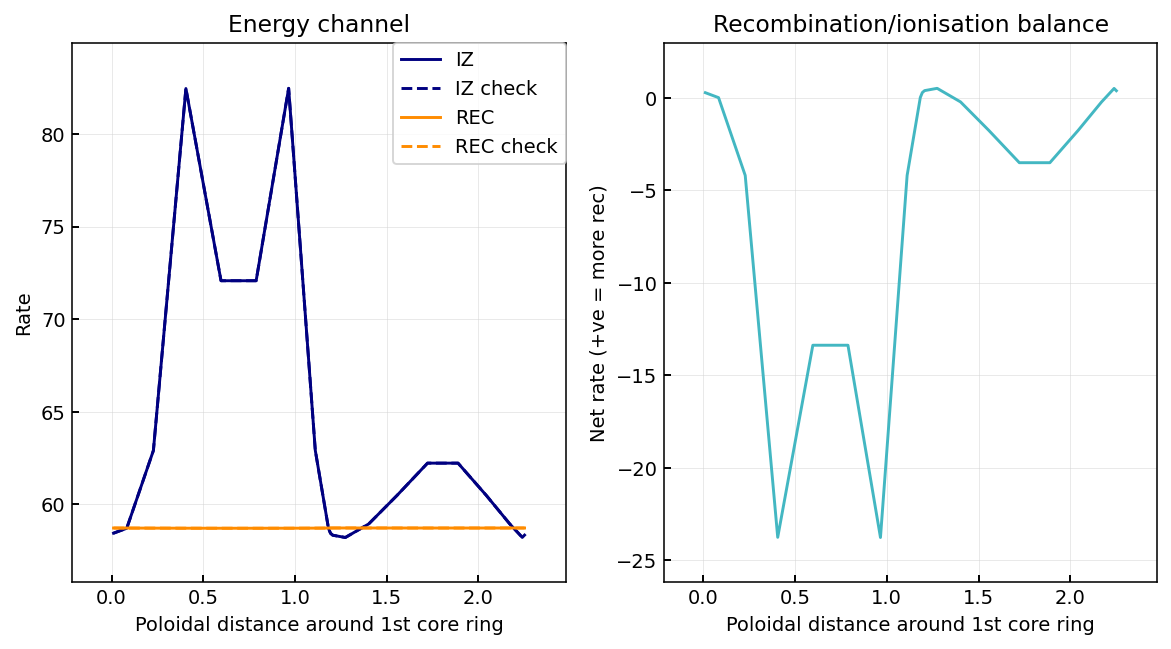

In [5]:
from general.rates import AMJUEL_rates
from sd1d.analysis import AMJUEL

reg = ds.hermesm.select_region("core_edge").squeeze()

Te = reg["Te"].values
Ne = reg["Ne"].values

amj = AMJUEL()
Krec = amj.amjuel_2d("rec", Te, Ne, data = AMJUEL_rates("rec"))
Kiz = amj.amjuel_2d("rec", Te, Ne, data = AMJUEL_rates("iz"))
Rrec = amj.amjuel_2d("rec", Te, Ne, data = AMJUEL_rates("Rrec"))

fig, axes = plt.subplots(1,2, figsize = (10,5))

x = reg["dl"].cumsum()

ax = axes[0]
ax.set_title("Energy channel")
# ax.set_yscale("log")
ax.plot(x, reg["Ed+_iz"], c = "navy", label = "IZ")
ax.plot(x, Kiz * reg["Ne"] * reg["Nd"] * reg["Td"] * (3/2) * constants("q_e"), c = "navy", ls = "--", label = "IZ check")
ax.plot(x, reg["Ed+_rec"]*-1, c = "darkorange", label = "REC")
ax.plot(x, Krec * reg["Ne"]**2 * reg["Td+"] * (3/2) * constants("q_e"), c = "darkorange", ls = "--", label = "REC check")
# ax.plot(x, reg["Rd+_rec"]*-1 - reg["Sd+_rec"]*13.6*constants("q_e"), c = "deeppink", label = "R_REC")
# ax.plot(x, Rrec * reg["Ne"]**2 * constants("q_e"), c = "deeppink", ls = "--", label = "RREC check")
ax.legend()
# ax2 = ax.twinx()
# ax2.plot(x, reg["Td"], alpha = 0.2, lw = 3, c = "red")

ax = axes[1]
# ax.set_title
ax.plot(x, reg["Ed+_iz"]*-1 + reg["Ed+_rec"]*-1)

axes[0].set_ylabel("Rate")
axes[1].set_ylabel("Net rate (+ve = more rec)")
axes[1].set_title("Recombination/ionisation balance")

for ax in axes:
    ax.set_xlabel("Poloidal distance around 1st core ring")

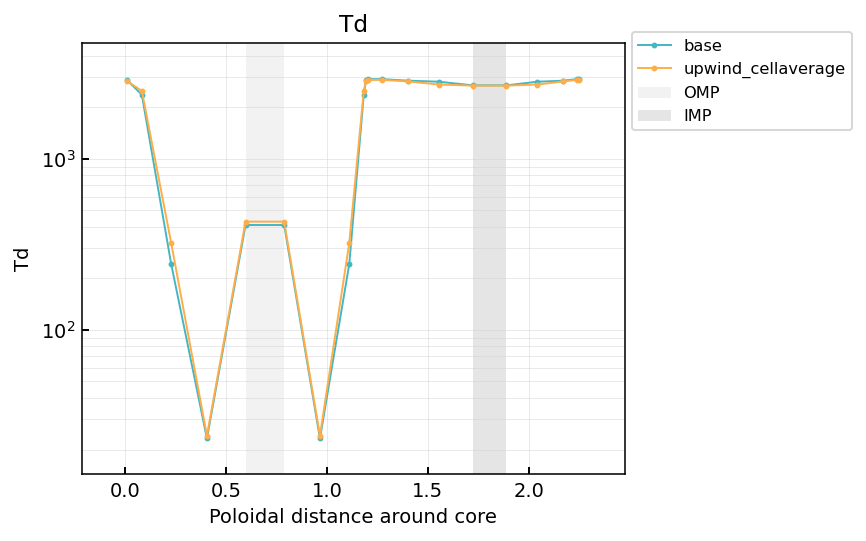

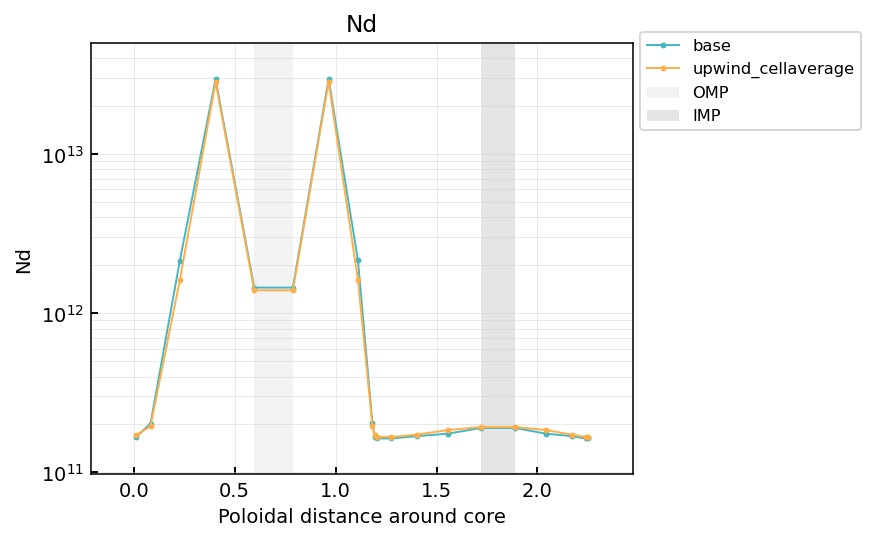

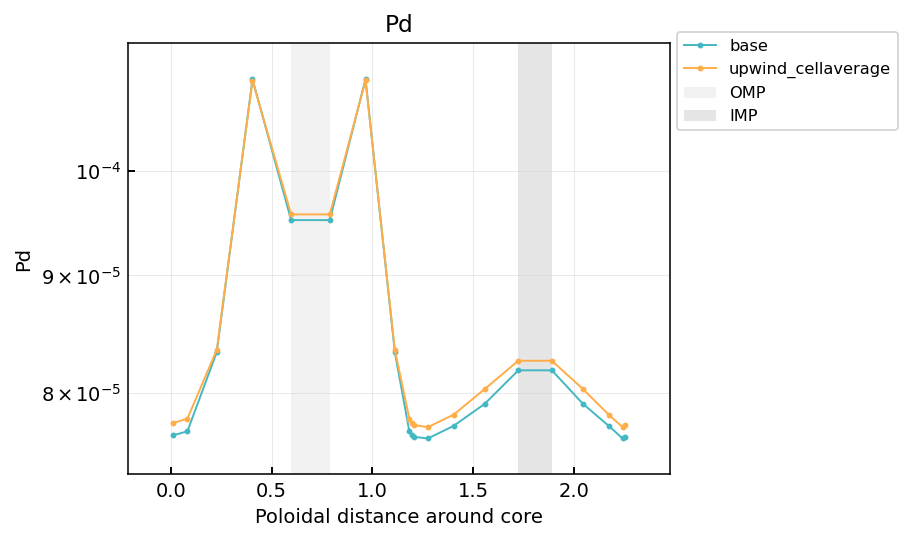

In [6]:
for param in ["Td", "Nd", "Pd"]:

    fig, ax = plt.subplots()
    m = ds.metadata
    ompA = int((m["j2_2g"] - m["j1_2g"]) / 2) + m["j1_2g"]
    ompB = int((m["j2_2g"] - m["j1_2g"]) / 2) + m["j1_2g"] + 1

    impA = int((m["j2_1g"] - m["j1_1g"]) / 2) + m["j1_1g"] + 1
    impB = int((m["j2_1g"] - m["j1_1g"]) / 2) + m["j1_1g"]


    for name in cs:
        ds = cs[name].ds.isel(t=-1)
        fl = ds.hermesm.select_region("core_edge").squeeze()
        x = fl["dl"].cumsum().values
        ax.plot(x, fl[param], label = name, marker = "o", lw = 1, ms = 2)

    indices = fl["theta_idx"].values
    indexmap = dict(zip(indices, x))
    ax.set_yscale("log")
    ylim = ax.get_ylim()
    ax.fill_betweenx([ylim[0], ylim[1]], indexmap[ompA], indexmap[ompB], color = "grey", alpha = 0.1, label = "OMP", linewidth = 0)
    ax.fill_betweenx([ylim[0], ylim[1]], indexmap[impA], indexmap[impB], color = "black", alpha = 0.1, label = "IMP", linewidth = 0)
    ax.set_ylim(ylim)
    fig.legend(bbox_to_anchor = (0.91,0.9), loc = "upper left", fontsize = "small")
    ax.set_xlabel("Poloidal distance around core")
    ax.set_ylabel(param)
    ax.set_title(param)